## Data Loading

In [1]:
import os
import torch
os.environ["TORCH"] = torch.__version__

import numpy as np
import torch_geometric
import torch_geometric.utils as utils
import networkx as nx

from matplotlib import pyplot as plt

from torch.nn import Linear, ReLU, functional as F, MSELoss
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import TopKPooling

%config InlineBackend.figure_format = 'svg'

In [2]:
dataset = torch.load("./graph_data_decoding_2023.pt")

In [3]:
print('====================')
print(f'Number of graphs: {len(dataset)}')
print('=============================================================')

data = dataset[20]  # Get one data point.

print('Some properties of a graph in the dataset:')
print()

print(data)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of node features: {data.num_node_features}')
print(data.y)

Number of graphs: 1000000
Some properties of a graph in the dataset:

Data(x=[5, 4], edge_index=[2, 20], edge_attr=[20, 1], y=[1, 2])
Number of nodes: 5
Number of edges: 20
Average node degree: 4.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of node features: 4
tensor([[1., 0.]])


In [4]:
num_samples = len(dataset)
train_data = dataset[int(.05 * num_samples):] # 95% training data
test_data = dataset[:int(.05 * num_samples)]  #  5% testing data
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

## Graph Neural Network
I started off going for a network based on GCN convolutions as their training time seems to be lowest by a large margin according to [Dwivedi, V. P., Joshi, C. K., Laurent, T., Bengio, Y. & Bresson, X.](https://arxiv.org/abs/2003.00982). I used *mean squared loss* for starters with an output shape of (1, 2) to avoid having to transform the labels. Later on I'll probably try transforming the labels to (1, 4) to be able to use *Categorical Cross Entropy*.

For now I've settled on splitting the network into one X-classifier and one Z-classifier with MSE Loss since Categorical Cross Entropy wouldn't change much for a single-class problem.

3 dense layers seems to lead to overfitting. 3 Convolutional layers seems to have issues with vanishing gradients, perhaps due to ReLU?
Removing the dropout layers instantly leads to overfitting.

Moving to just classifying X seems to have greatly increased accuracy. Hopefully Z will turn out the same way. I can't figure out a good way to TopKPool since some networks apparently contain just a single node. It is possible with $k=1$ and I'd argue that is still valuable since the nodes chosen is a learned parameter and it doesn't meaningfully slow down learning.

In [21]:
from typing import List

NODE_FEATURES = 4

NETWORK_X = 0
NETWORK_Z = 1

class GNN(torch.nn.Module):
    def __init__(self, feature_class=NETWORK_X):
        super().__init__()
        torch.manual_seed(1234567)
        
        self.feature_class = feature_class
        
        self.conv1 = GATConv(NODE_FEATURES, 128)
        self.conv2 = GATConv(128, 64)
        self.topk_pool = TopKPooling(64, ratio=1)
        
        self.dense1 = Linear(64, 1)
        
    
    def forward(self, x, edge_index, batch, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        # x = global_mean_pool(x, batch)
        (x, edge_index, edge_attr, batch, perm, _) = self.topk_pool(x, edge_index, edge_attr, batch)
        
        x = F.dropout(x, p=0.5, training=self.training) # Noise should help during training
        x = self.dense1(x)
        x = x.relu()
        
        # x = F.softmax(x, dim=1)
        return x
    
    def train_batch(self, optimizer, criterion, batch):
        self.train()
        optimizer.zero_grad()
        out = self(batch.x, batch.edge_index, batch.batch, batch.edge_attr)
        if self.feature_class == NETWORK_X:
            loss = criterion(out, batch.y[:,0:1])
        elif self.feature_class == NETWORK_Z:
            loss = criterion(out, batch.y[:,1:2])
        loss.backward()
        optimizer.step()
        return loss
    
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index, data.batch, data.edge_attr)
        pred = torch.round(out)
        if self.feature_class == NETWORK_X:
            test_correct = (pred == data.y[:,0:1]).all(dim=1)
        elif self.feature_class == NETWORK_Z:
            test_correct = (pred == data.y[:,1:2]).all(dim=1)
        test_acc = int(test_correct.sum()) / int(pred.size()[0])
        return test_acc
    
    def test_predictions(self, data):
        self.eval()
        out = self(data.x, data.edge_index, data.batch, batch.edge_attr)
        pred = torch.round(out)
        return pred

In [56]:
import time

def train_model(model, EPOCHS=5):
    criterion = MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0015, amsgrad=True)
    start_time = time.time()
    losses = np.zeros(EPOCHS)
    train_accs = np.zeros(EPOCHS)
    test_accs = np.zeros(EPOCHS)
    epochs = np.arange(EPOCHS)

    for epoch in range(EPOCHS):
        # There are 950 batches for training
        for batch in train_loader:
            loss = model.train_batch(optimizer, criterion, batch)
            losses[epoch] += loss

            train_acc = model.test(batch)
            train_accs[epoch] += train_acc

        # There are 50 batches for testing
        batches = 0
        for batch in test_loader:
            test_acc = model.test(batch)
            test_accs[epoch] += test_acc
            batches += 1

        print(f"Epoch: {epoch:02d} Loss: {losses[epoch]/950:.4f} Training Acc: {train_accs[epoch]/950:.4f} Testing Acc: {test_accs[epoch]/50:.4f} Seconds elapsed: {int(time.time() - start_time)}")

    losses = losses / 950
    test_accs = test_accs / 50
    train_accs = train_accs / 950
    
    return (epochs, losses, train_accs, test_accs)


In [60]:

model_x = GNN(NETWORK_X)
print(model_x)

GNN(
  (conv1): GATConv(4, 128, heads=1)
  (conv2): GATConv(128, 64, heads=1)
  (topk_pool): TopKPooling(64, ratio=1, multiplier=1.0)
  (dense1): Linear(in_features=64, out_features=1, bias=True)
)


Epoch: 00 Loss: 0.0345 Training Acc: 0.9595 Testing Acc: 0.9599 Seconds elapsed: 41
Epoch: 01 Loss: 0.0341 Training Acc: 0.9601 Testing Acc: 0.9611 Seconds elapsed: 83
Epoch: 02 Loss: 0.0336 Training Acc: 0.9604 Testing Acc: 0.9621 Seconds elapsed: 125
Epoch: 03 Loss: 0.0335 Training Acc: 0.9607 Testing Acc: 0.9590 Seconds elapsed: 167
Epoch: 04 Loss: 0.0334 Training Acc: 0.9607 Testing Acc: 0.9602 Seconds elapsed: 209
Epoch: 05 Loss: 0.0329 Training Acc: 0.9614 Testing Acc: 0.9613 Seconds elapsed: 251
Epoch: 06 Loss: 0.0328 Training Acc: 0.9615 Testing Acc: 0.9603 Seconds elapsed: 293
Epoch: 07 Loss: 0.0328 Training Acc: 0.9612 Testing Acc: 0.9618 Seconds elapsed: 335
Epoch: 08 Loss: 0.0323 Training Acc: 0.9619 Testing Acc: 0.9636 Seconds elapsed: 377
Epoch: 09 Loss: 0.0321 Training Acc: 0.9621 Testing Acc: 0.9619 Seconds elapsed: 419
Epoch: 10 Loss: 0.0318 Training Acc: 0.9625 Testing Acc: 0.9630 Seconds elapsed: 461
Epoch: 11 Loss: 0.0316 Training Acc: 0.9628 Testing Acc: 0.9593 Sec

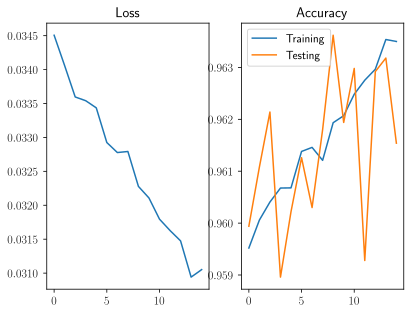

In [68]:
(epochs, losses, train_accs, test_accs) = train_model(model_x, EPOCHS=15)
plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Training")
plt.plot(epochs, test_accs, label="Testing")
plt.title("Accuracy")
plt.legend()

plt.show()

In [62]:
model_z = GNN(NETWORK_Z)
print(model_z)

GNN(
  (conv1): GATConv(4, 128, heads=1)
  (conv2): GATConv(128, 64, heads=1)
  (topk_pool): TopKPooling(64, ratio=1, multiplier=1.0)
  (dense1): Linear(in_features=64, out_features=1, bias=True)
)


Epoch: 00 Loss: 0.0326 Training Acc: 0.9622 Testing Acc: 0.9600 Seconds elapsed: 45
Epoch: 01 Loss: 0.0319 Training Acc: 0.9632 Testing Acc: 0.9600 Seconds elapsed: 89
Epoch: 02 Loss: 0.0315 Training Acc: 0.9633 Testing Acc: 0.9615 Seconds elapsed: 134
Epoch: 03 Loss: 0.0309 Training Acc: 0.9639 Testing Acc: 0.9609 Seconds elapsed: 178
Epoch: 04 Loss: 0.0307 Training Acc: 0.9642 Testing Acc: 0.9629 Seconds elapsed: 222
Epoch: 05 Loss: 0.0303 Training Acc: 0.9644 Testing Acc: 0.9628 Seconds elapsed: 266
Epoch: 06 Loss: 0.0299 Training Acc: 0.9648 Testing Acc: 0.9621 Seconds elapsed: 314
Epoch: 07 Loss: 0.0294 Training Acc: 0.9652 Testing Acc: 0.9643 Seconds elapsed: 359
Epoch: 08 Loss: 0.0293 Training Acc: 0.9653 Testing Acc: 0.9641 Seconds elapsed: 401
Epoch: 09 Loss: 0.0292 Training Acc: 0.9654 Testing Acc: 0.9636 Seconds elapsed: 442
Epoch: 10 Loss: 0.0286 Training Acc: 0.9658 Testing Acc: 0.9610 Seconds elapsed: 484
Epoch: 11 Loss: 0.0288 Training Acc: 0.9658 Testing Acc: 0.9635 Sec

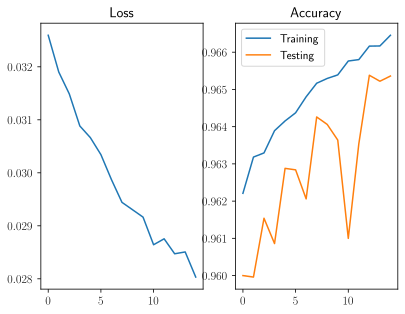

In [66]:
(epochs, losses, train_accs, test_accs) = train_model(model_z, EPOCHS=15)
plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Training")
plt.plot(epochs, test_accs, label="Testing")
plt.title("Accuracy")
plt.legend()

plt.show()

In [69]:
acc = 0.0

for batch in test_loader:
    x_preds = model_x.test_predictions(batch).detach().numpy()
    z_preds = model_z.test_predictions(batch).detach().numpy()
    
    total_preds = np.empty((x_preds.shape[0], 2))
    total_preds[:,0] = x_preds[:,0]
    total_preds[:,1] = z_preds[:,0]
    
    correct = np.count_nonzero((total_preds == batch.y.numpy()).all(axis=1))
    acc += correct / (1000 * 50)

print(acc)

0.9306000000000003
